In [141]:
import logging

import numpy as np
import imageio as io
import matplotlib.pyplot as plt

from PIL import Image
from scipy import misc
from scipy import ndimage
from time import time

In [2]:
import warnings
warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO)

## Load images & generate rescales

In [133]:
TEMPLATE_IMAGE = 'data/template.jpg'
K = np.sqrt(2)
SIGMA = 1.6
DOG_THRESHOLD = 0.03
EDGE_THRESHOLD = 10 
X_HAT_THRESHOLD = 0.5

NB_OCTAVES = 4
NB_OCTAVE_LAYERS = 6

#s = 3
#k = 2 ** (1.0 / s)

In [180]:
def image2nparray(img):
    return np.asarray(img,dtype='float64')/255.
    
def load_gray_octaves(imagename, nb_octaves = NB_OCTAVES, subsampling = False):
    img = Image.open(imagename).convert('L')
    h, w = img.size
    
    if subsampling:
        scaled_imgs = [ img.resize((h//subsampling, w//subsampling), resample = Image.BILINEAR) ]
    else:
        scaled_imgs = [ img.resize((2*h, 2*w), resample = Image.BILINEAR) ] # double sized image
    
    for octave in range(nb_octaves-1):
        ocatave_size = (h//(octave+1), w//(octave+1))
        scaled_img = scaled_imgs[-1].resize(ocatave_size, resample=Image.BILINEAR)
        scaled_imgs.append(scaled_img)
        
    gray_scaled_imgs = [image2nparray(scaled_img) for scaled_img in scaled_imgs]

    return gray_scaled_imgs

def show_gray(img):
    plt.figure(figsize=(10,10))
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.show()

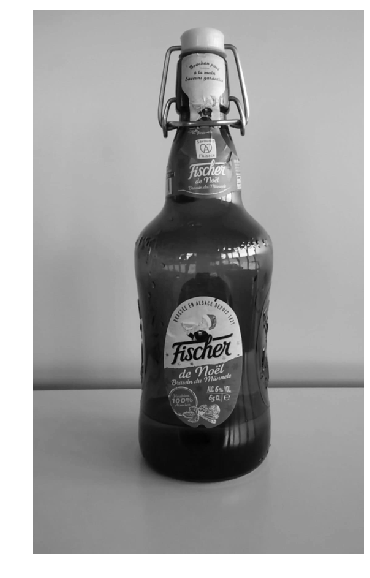

In [181]:
scaled_imgs = load_gray_octaves(TEMPLATE_IMAGE, subsampling=2)
show_gray(scaled_imgs[0]) # normal size

## Sigmas for gaussian filter

In [182]:
def sigmas_for_octave_layer(octave, nb_octave_layers = NB_OCTAVE_LAYERS):
    k_offset = 2 * octave
    
    octave_sigmas = np.array([
        round(SIGMA * ( K ** ( octave_layer + k_offset ) ), 4)
        for octave_layer in range(nb_octave_layers)
    ])
    logging.info('Octave #{} - Sigmas: {} - k_offset: {}'.format(octave, list(octave_sigmas), k_offset))
    
    return octave_sigmas

# kvectotal = np.array([1.6, 1.6 * k, 1.6 * (k ** 2), 1.6 * (k ** 3), 1.6 * (k ** 4), 1.6 * (k ** 5), 1.6 * (k ** 6), 1.6 * (k ** 7), 1.6 * (k ** 8), 1.6 * (k ** 9), 1.6 * (k ** 10), 1.6 * (k ** 11)])

SIGMAS = [ sigmas_for_octave_layer( octave ) for octave in range( NB_OCTAVES ) ]

INFO:root:Octave #0 - Sigmas: [1.6, 2.2627, 3.2, 4.5255, 6.4, 9.051] - k_offset: 0
INFO:root:Octave #1 - Sigmas: [3.2, 4.5255, 6.4, 9.051, 12.8, 18.1019] - k_offset: 2
INFO:root:Octave #2 - Sigmas: [6.4, 9.051, 12.8, 18.1019, 25.6, 36.2039] - k_offset: 4
INFO:root:Octave #3 - Sigmas: [12.8, 18.1019, 25.6, 36.2039, 51.2, 72.4077] - k_offset: 6


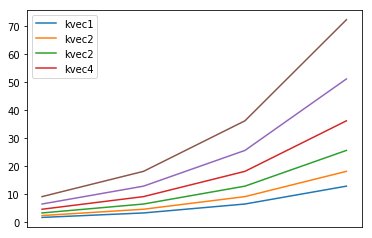

In [183]:
plt.plot(SIGMAS)
plt.legend(['kvec1', 'kvec2' ,'kvec2','kvec4'])
plt.xticks([])
plt.show()

## Applying Gaussian Filters

In [184]:
def compute_octaves(scaled_images, nb_octaves_layers = NB_OCTAVE_LAYERS, sigmas = SIGMAS):
    octaves = [ np.zeros((*img.shape, nb_octaves_layers)) for img in scaled_images ]
    for i_octave, octave in enumerate(octaves):
        for octave_layer in range(nb_octaves_layers):
            doubled_img = scaled_images[0]
            sigma = sigmas[i_octave][octave_layer]
            octave_size = octave.shape[:2]
            octave[:,:,octave_layer] = misc.imresize(ndimage.filters.gaussian_filter(doubled_img, sigma), size=octave_size, interp='bilinear')/255.
            
    return octaves
        

In [185]:
OCTAVES = compute_octaves(scaled_imgs)

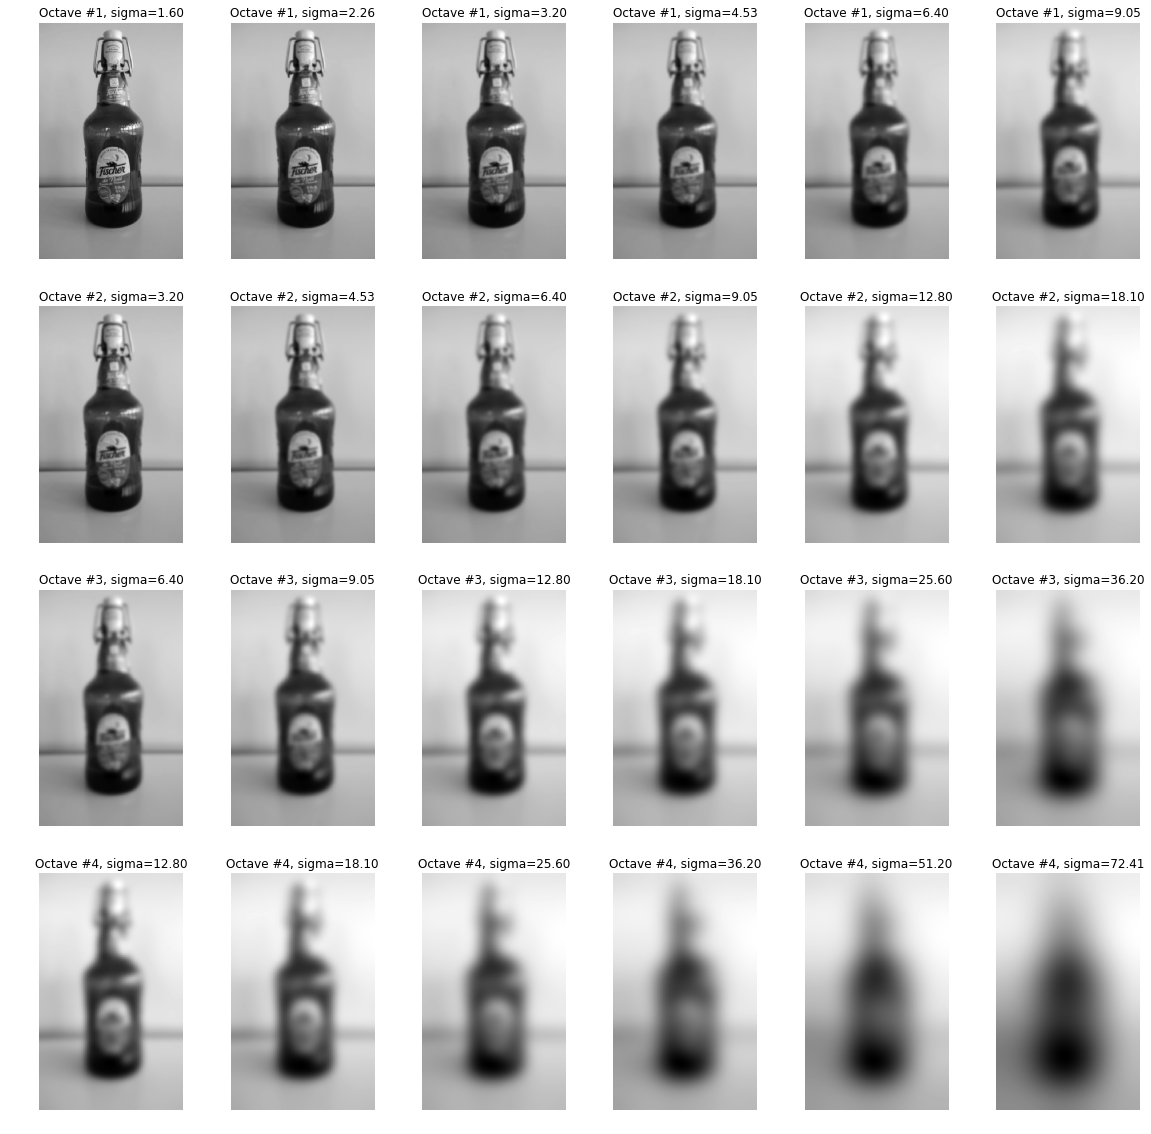

In [186]:
plt.figure(figsize=(20,20))
for octave in range(NB_OCTAVES):
    for octave_layer in range(NB_OCTAVE_LAYERS):
        plt.subplot(NB_OCTAVES, NB_OCTAVE_LAYERS, octave_layer+6*octave+1)
        plt.imshow(OCTAVES[octave][:,:,octave_layer],cmap='gray')
        plt.title('Octave #%d, sigma=%.2f' %(octave+1, SIGMAS[octave][octave_layer]))
        plt.axis('off')
plt.show()

## Computing DoG pyramids

In [187]:
DoGs = [np.diff(octave, axis=-1) for octave in OCTAVES]

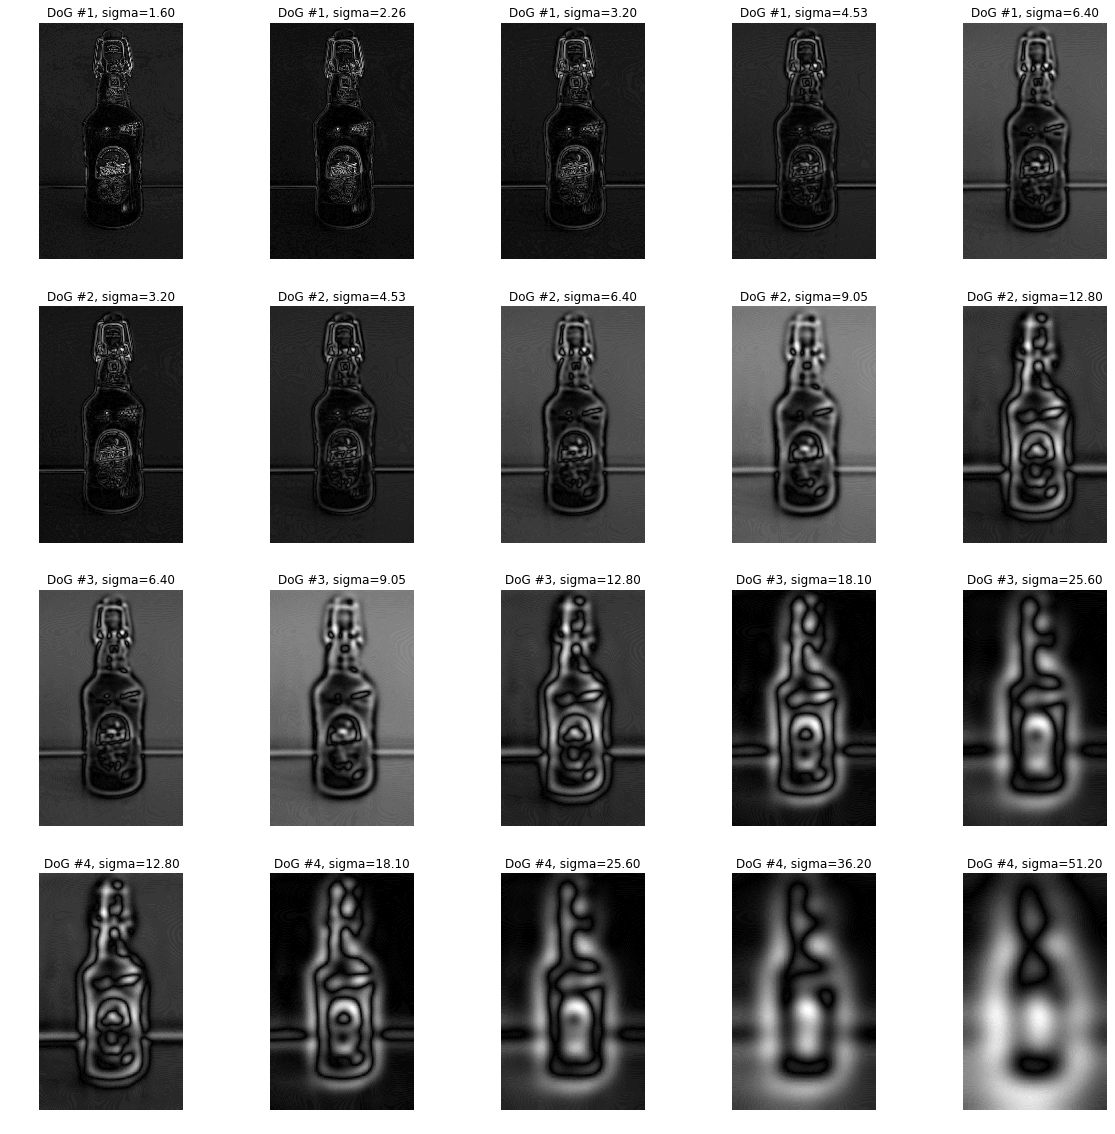

In [188]:
def plot_dogs(dogs):
    nb_octaves = len(dogs)
    nb_dog_layers = dogs[0].shape[-1]
    
    plt.figure(figsize=(20,20))
    for octave in range(nb_octaves):
        for dog_layer in range(nb_dog_layers):
            plt.subplot(nb_octaves,nb_dog_layers, dog_layer+nb_dog_layers*octave+1)
            plt.imshow(abs(dogs[octave][:,:,dog_layer]),cmap='gray')
            plt.title('DoG #%d, sigma=%.2f' %(octave+1, SIGMAS[octave][dog_layer]))
            plt.axis('off')
            
    plt.show()
    
plot_dogs(DoGs)

## Extrema detection
In each of the following for loops, elements of each pyramids that are larger or smaller than its 26 immediate neighbors in space and scale are labeled as extrema. As explained in section 4 of Lowe's paper, these initial extrema are pruned by checking that their contrast and curvature are above certain thresholds. The thresholds used here are those suggested by Lowe. 

### Finding the threshold

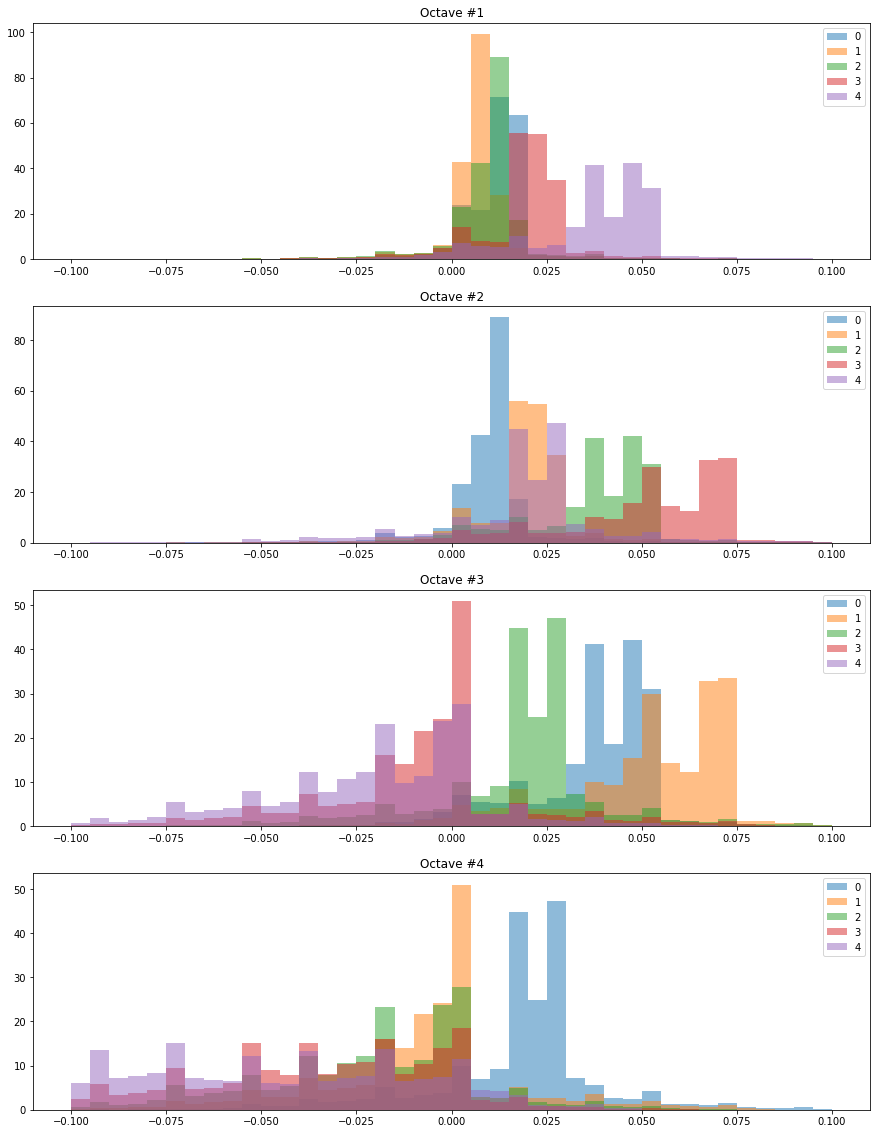

In [189]:
def plot_hist_dogs(dogs):
    nb_octaves = len(dogs)
    nb_dog_layers = dogs[0].shape[-1]
    
    plt.figure(figsize=(15,20))
    for i_octave in range(nb_octaves):
        plt.subplot('41%d' %(i_octave+1))
        for i_dog_layer in range(nb_dog_layers):
            plt.hist(dogs[i_octave][:,:,i_dog_layer].reshape(-1), bins = 40, range=(-0.1, 0.1), label ='%d'%i_dog_layer, normed=True, alpha=0.5) 
        plt.legend()
        plt.title('Octave #%d' %(i_octave+1))
    plt.show()
    
plot_hist_dogs(DoGs)

In [190]:
def keypoints(octave_dogs, threshold = DOG_THRESHOLD, r = EDGE_THRESHOLD, x_hat_thresh = X_HAT_THRESHOLD):
    xextr, yextr, dxextr, dyextr, maskextr  = [], [], [], [], []
    h, w = octave_dogs.shape[:2]
    for i in range(1,octave_dogs.shape[2]-1):
        for j in range(80, h - 80):
            for k in range(80, w - 80):
                if np.absolute(octave_dogs[j, k, i]) < threshold:
                    continue

                maxbool = (octave_dogs[j, k, i] > 0)
                minbool = (octave_dogs[j, k, i] < 0)

                for di in range(-1, 2):
                    for dj in range(-1, 2):
                        for dk in range(-1, 2):
                            if di == 0 and dj == 0 and dk == 0:
                                continue

                            maxbool = maxbool and (octave_dogs[j, k, i] > octave_dogs[j + dj, k + dk, i + di])
                            minbool = minbool and (octave_dogs[j, k, i] < octave_dogs[j + dj, k + dk, i + di])
                 
                            if not maxbool and not minbool:
                                break

                        if not maxbool and not minbool:
                            break

                    if not maxbool and not minbool:
                        break

                if maxbool or minbool:
                    dx = (octave_dogs[j, k+1, i] - octave_dogs[j, k-1, i]) * 0.5
                    dy = (octave_dogs[j+1, k, i] - octave_dogs[j-1, k, i]) * 0.5
                    ds = (octave_dogs[j, k, i+1] - octave_dogs[j, k, i-1]) * 0.5
                    dxx = (octave_dogs[j, k+1, i] + octave_dogs[j, k-1, i] - 2 * octave_dogs[j, k, i]) * 1.0       
                    dyy = (octave_dogs[j+1, k, i] + octave_dogs[j-1, k, i] - 2 * octave_dogs[j, k, i]) * 1.0       
                    dss = (octave_dogs[j, k, i+1] + octave_dogs[j, k, i-1] - 2 * octave_dogs[j, k, i]) * 1.0
                    dxy = (octave_dogs[j+1, k+1, i] - octave_dogs[j+1, k-1, i] - octave_dogs[j-1, k+1, i] + octave_dogs[j-1, k-1, i]) * 0.25 
                    dxs = (octave_dogs[j, k+1, i+1] - octave_dogs[j, k-1, i+1] - octave_dogs[j, k+1, i-1] + octave_dogs[j, k-1, i-1]) * 0.25 
                    dys = (octave_dogs[j+1, k, i+1] - octave_dogs[j-1, k, i+1] - octave_dogs[j+1, k, i-1] + octave_dogs[j-1, k, i-1]) * 0.25  

                    dD = np.matrix([[dx], [dy], [ds]])
                    H = np.matrix([[dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]])
                    x_hat = np.linalg.lstsq(H, dD)[0]
                    D_x_hat = octave_dogs[j, k, i] + 0.5 * np.dot(dD.transpose(), x_hat)

                    xextr.append(j)
                    yextr.append(k)
                    dxextr.append(dx)
                    dyextr.append(dy)
                    maskextr.append(0)
                    
                    if np.all(np.abs(x_hat) < x_hat_thresh):
                        maskextr[-1]=1
                    
                        if np.absolute(D_x_hat) > threshold:
                            maskextr[-1]=2
                            
                            trace = dxx + dyy
                            det = dxx * dyy - (dxy ** 2)
                    
                            if (trace ** 2) * r < det * ((r + 1) ** 2):
                                #extrpyrlvl1[j, k, i - 1] = 1
                                maskextr[-1] = 3
                                
    return np.array(xextr), np.array(yextr), np.array(dxextr), np.array(dyextr), np.array(maskextr)

In [192]:
def keypoints_all_octaves(dogs, threshold = DOG_THRESHOLD, r = EDGE_THRESHOLD, x_hat_thresh = X_HAT_THRESHOLD):
    all_keypoints = list()
    
    for i_dog, dog in enumerate(DoGs):
        start = time()
        all_keypoints.append(keypoints(dog, threshold, r, x_hat_thresh))
        logging.info('Keypoint for DoG #{} - {}sec'.format(i_dog, round(time()-start, 1)))
        
    return all_keypoints
        
all_kp = keypoints_all_octaves(DoGs, r = 3)

INFO:root:Keypoint for DoG #0 - 1.4sec
INFO:root:Keypoint for DoG #1 - 21.6sec
INFO:root:Keypoint for DoG #2 - 3.6sec
INFO:root:Keypoint for DoG #3 - 1.2sec


In [174]:
# xextr, yextr, dxextr, dyextr, maskextr = keypoints(DoGs[0])

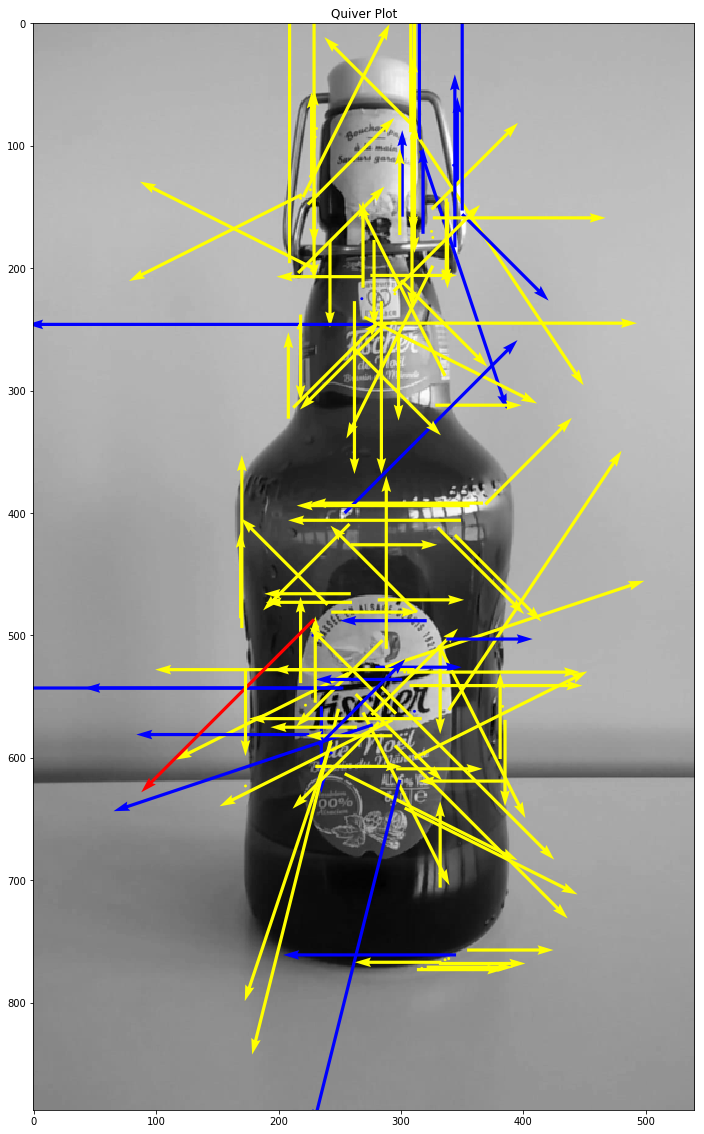

In [193]:
def plot_keypoints(scaled_img, mask_level, xextr, yextr, dxextr, dyextr, maskextr):
    
    mask = maskextr >= mask_level
    
    colors = {1: 'red', 2: 'blue', 3: 'yellow'}
    
    fig, ax = plt.subplots(figsize=(20,20))
    im = ax.imshow(scaled_img, cmap='gray')
    
    c_map = [colors[mask_lvl] for mask_lvl in maskextr[mask]]
    ax.quiver(yextr[mask], xextr[mask], dyextr[mask], dxextr[mask], color=c_map, norm=None,scale=0.015)

    ax.set(aspect=1, title='Quiver Plot')
    plt.show()

octave_lvl = 0  
plot_keypoints(scaled_imgs[octave_lvl], 1, *all_kp[octave_lvl])

[]

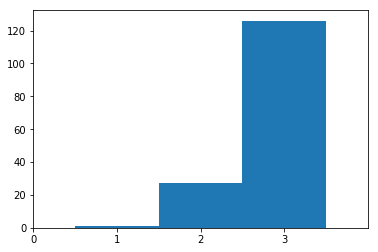

In [202]:
bins = np.arange(1,5) - 0.5
plt.hist(all_kp[octave_lvl][4], bins)
plt.xticks(range(4))
plt.xlim([0, 4])
plt.plot()